In [1]:
# !pip install haystack-ai
# !pip install "datasets>=2.6.1"
# !pip install "sentence-transformers>=2.2.0"
# !pip install -U transformers
# !pip install accelerate

In [1]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

In [2]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("anakin87/medrag-pubmed-chunk", split="train")

docs = []
for doc in dataset:
    docs.append(
        Document(content=doc["contents"], meta={"title": doc["title"], "abstract": doc["content"], "pmid": doc["id"]})
    )

Generating train split:   0%|          | 0/15377 [00:00<?, ? examples/s]

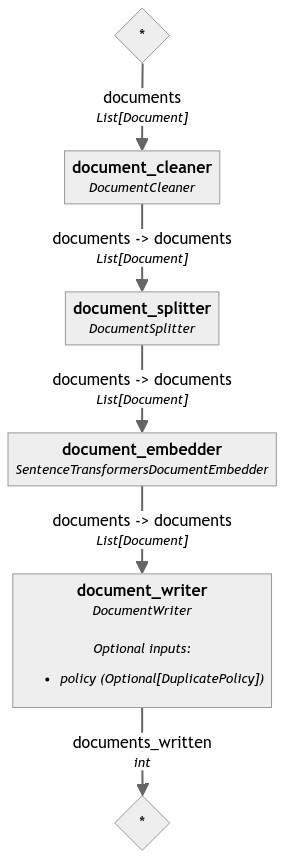

In [7]:
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.preprocessors.document_cleaner import DocumentCleaner
from haystack import Pipeline
from haystack.utils import ComponentDevice

document_cleaner = DocumentCleaner(
    remove_empty_lines=True,
	remove_extra_whitespaces=True,
	remove_repeated_substrings=False
)
# device = ComponentDevice.from_str("cuda:0")
device = ComponentDevice.from_str("cpu")
document_splitter = DocumentSplitter(split_by="word", split_length=512, split_overlap=32)
document_embedder = SentenceTransformersDocumentEmbedder(
    model="BAAI/bge-small-en-v1.5", meta_fields_to_embed=["title"], device=device
)
document_writer = DocumentWriter(document_store)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_cleaner", document_cleaner)
indexing_pipeline.add_component("document_splitter", document_splitter)
indexing_pipeline.add_component("document_embedder", document_embedder)
indexing_pipeline.add_component("document_writer", document_writer)

indexing_pipeline.connect("document_cleaner", "document_splitter")
indexing_pipeline.connect("document_splitter", "document_embedder")
indexing_pipeline.connect("document_embedder", "document_writer")

In [8]:
indexing_pipeline.run({"document_cleaner": {"documents": docs[:len(docs)//2]}})

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 7690}}

In [9]:
len(document_store.storage.keys())

7690

In [16]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(
    model="BAAI/bge-small-en-v1.5", device=device
)
embedding_retriever = InMemoryEmbeddingRetriever(document_store)
bm25_retriever = InMemoryBM25Retriever(document_store)

In [17]:
from haystack.components.joiners import DocumentJoiner

document_joiner = DocumentJoiner(join_mode='reciprocal_rank_fusion', top_k=3)

In [18]:
from haystack.components.rankers import TransformersSimilarityRanker, LostInTheMiddleRanker

ranker = TransformersSimilarityRanker(model="BAAI/bge-reranker-base")
lost_in_the_middle_ranker = LostInTheMiddleRanker(word_count_threshold=1024, top_k=3)

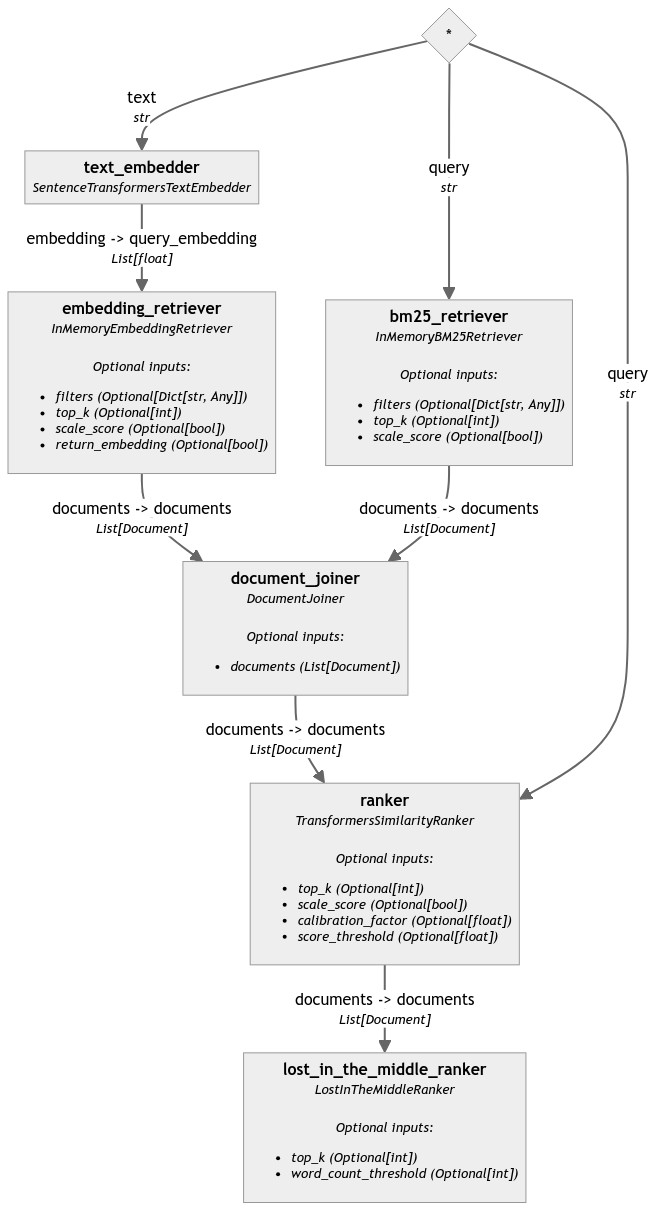

In [19]:
from haystack import Pipeline

hybrid_retrieval = Pipeline()
hybrid_retrieval.add_component("text_embedder", text_embedder)
hybrid_retrieval.add_component("embedding_retriever", embedding_retriever)
hybrid_retrieval.add_component("bm25_retriever", bm25_retriever)
hybrid_retrieval.add_component("document_joiner", document_joiner)
hybrid_retrieval.add_component("ranker", ranker)
hybrid_retrieval.add_component("lost_in_the_middle_ranker", lost_in_the_middle_ranker)

hybrid_retrieval.connect("text_embedder", "embedding_retriever")
hybrid_retrieval.connect("bm25_retriever", "document_joiner")
hybrid_retrieval.connect("embedding_retriever", "document_joiner")
hybrid_retrieval.connect("document_joiner", "ranker")
hybrid_retrieval.connect("ranker", "lost_in_the_middle_ranker")

In [20]:
hybrid_retrieval.draw("hybrid-retrieval.png")

In [21]:
query = "apnea in infants"

result = hybrid_retrieval.run(
    {"text_embedder": {"text": query}, "bm25_retriever": {"query": query}, "ranker": {"query": query}}
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ranking by BM25...:   0%|          | 0/7690 [00:00<?, ? docs/s]

In [22]:
def pretty_print_results(prediction):
    for doc in prediction["documents"]:
        print(doc.meta["title"], "\t", doc.score)
        print(doc.meta["abstract"])
        print("\n", "\n")

In [23]:
pretty_print_results(result["lost_in_the_middle_ranker"])

Efficacy of caffeine in treatment of apnea in the low-birth-weight infant. 	 0.9170230627059937
The efficacy of caffeine citrate in the management of apnea in the newborn infant was evaluated. Caffeine citrate was given to 18 preterm neonates with recurrent apneic spells. Mean (+/- SE) birth weight and gestational age were 1,065.0 +/- 71.9 gm and 27.5 +/- 0.6 weeks, respectively. Mean age at onset of apnea and at initiation of caffeine treatment was 6.5 +/- 3.7 days and 18.2 +/- 4.9 days, respectively. Caffeine citrate was administered with a loading dose of 20 mg/kg intravenously followed within two to three days by 5 to 10 mg/kg once or twice daily. All infants except one showed a significant decrease in the frequency of apneic episodes associated with caffeine therapy. Mean frequencies of apneic spells were 13.6 +/- 2.5 and 2.1 +/- 0.6 apnea per day before and after initiation of caffeine treatment, respectively. Respiratory rate was increased, and blood [h]+ion concentration and Pc

In [24]:
indexing_pipeline.run({"document_cleaner": {"documents": docs[len(docs)//2:]}})
len(document_store.storage.keys())

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

15380

In [25]:
query = "apnea in infants"

result = hybrid_retrieval.run(
    {"text_embedder": {"text": query}, "bm25_retriever": {"query": query}, "ranker": {"query": query}}
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ranking by BM25...:   0%|          | 0/15380 [00:00<?, ? docs/s]

In [26]:
pretty_print_results(result["lost_in_the_middle_ranker"])

Physiologic changes induced by theophylline in the treatment of apnea in preterm infants. 	 0.9714499115943909
Ten preterm infants (birth weight 0.970 to 2.495 kg) with apnea due to periodic breathing (apneic interval = 5 to 10 seconds) or with "serious apnea" (greater than or equal to 20 seconds) were studied before and after the administration of theophylline. We determined the incidence of apnea, respiratory minute volume, alveolar gases, arterial gases and pH, "specific" compliance, functional residual capacity, and work of breathing. Theophylline decreased the incidence of apnea (P less than .05), increased respiratory minute volume (P less than 0.001), decreased (PACO2 (and PaCO2 P less than 0.001), increased the slope of the CO2 response curve (P less than 0.02) with a significant shift to the left (P less than 0.02). These findings suggest that the decreased incidence of apnea after theophylline is associated with an increase in alveolar ventilation and increased sensitivity to